In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# seting the working directory
%cd /content/drive/MyDrive/Sentiment_Analysis_Project
!ls

/content/drive/MyDrive/Sentiment_Analysis_Project
a1_IMDB_Dataset.csv	    a4_LSTM_Predictions.csv
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.864.h5
a3_IMDb_Unseen_Reviews.csv  Movie_review_sentiment_analysis.ipynb


In [5]:
!pip install tensorflow

In [6]:
# importing essential libs
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from sklearn.model_selection import train_test_split

#Loading dataset

In [7]:
#Loading dataset

#importing IMDb Movie RevDataset
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")


In [8]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [9]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# Checking for missing values

movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

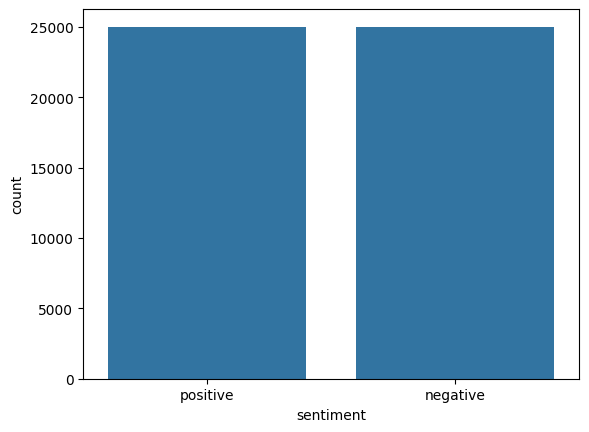

In [11]:
#Data distribution p/n

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

#Data Preprocessing :(

In [12]:
movie_reviews['review'][2]

#We will now refine the text by removing everything that is not important

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [13]:
import re
from nltk.corpus import stopwords

TAG_RE = re.compile(r'<[^>]+>') # find anything between < and >

def remove_tags(text):
  #replace anything in <> with space
  return TAG_RE.sub('', text)

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
def preprocess_text(sen):
  '''clean the data leaving only two or more character long non-step words composed of a to z and small A to Z only and lowercase'''
  sentence = sen.lower()
  #remove tags
  sentence = remove_tags(sentence)
  #remove puncs and nums
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  #remove single char
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  #remove multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  #remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)
  return sentence

In [16]:
X=[]
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [17]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [18]:
# Converting the p/n to 1/0
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train ,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
#spliting data

# Embedding
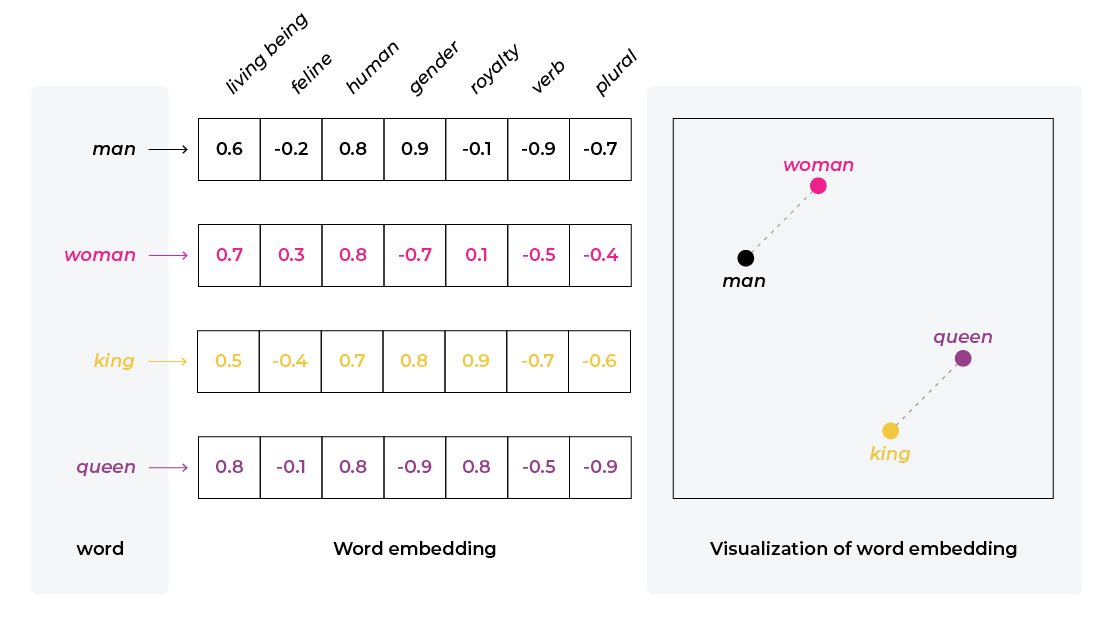

In [20]:
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [21]:
vocab_lenght = len(word_tokenizer.word_index) + 1
vocab_lenght

92394

In [22]:
#padding to make a fixed lenght 100
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
#we use GloVe as a pre-trained to set word embeddings
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vectors = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vectors
glove_file.close()




In [24]:
#Create Embedding Matrix having 100 columns
# ind - word

embeddings_matrix = zeros((vocab_lenght, 100))
for word ,ind in word_tokenizer.word_index.items():
  embeddings_vector = embeddings_dictionary.get(word)
  if embeddings_vector is not None:
    embeddings_matrix[ind] = embeddings_vector

In [53]:
embeddings_matrix.shape

(92394, 100)

In [54]:
embeddings_matrix[2]

array([ 0.19915999, -0.049702  ,  0.24579   , -0.32280999,  0.89767998,
       -0.1278    , -0.49506   ,  0.20814   , -0.20046   , -0.20603999,
        0.038292  , -0.67277002, -0.12689   , -0.18765999, -0.10277   ,
        0.73128003,  0.82407999,  0.087288  ,  0.69255   ,  1.31070006,
        0.49112999, -0.38097   ,  0.24338   , -0.27812999,  0.62506002,
        0.35978001,  0.42041001, -0.24529   ,  0.14861   , -0.26725999,
       -0.56261998,  0.63843   , -0.54153001,  0.36537001,  0.20545   ,
       -0.16604   ,  0.72434002,  0.29960999, -0.42501   , -0.35932001,
       -0.089288  ,  0.48752001, -1.0927    ,  0.88818002,  0.89941001,
       -0.75410002, -0.35492   , -0.76396   ,  0.27467999,  0.2757    ,
       -0.48152   , -0.41398999,  0.64489001,  1.148     , -0.29131001,
       -2.93869996, -0.83161998,  0.95586002,  1.16229999, -0.42502001,
        0.15486   ,  2.23259997, -0.31338999, -0.030228  ,  0.79802001,
       -0.41302001,  0.72885001,  0.72960001, -0.31909001,  0.89

# Simple Neural Net model

In [26]:
# Neural Network architecture
from tensorflow.keras.layers import Embedding

snn_model = Sequential()
embedding_layer = Embedding(vocab_lenght, 100, weights=[embeddings_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
#model Compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [28]:
#Model training

history = snn_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.6614 - loss: 0.6083 - val_acc: 0.7619 - val_loss: 0.5018
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8013 - loss: 0.4425 - val_acc: 0.7653 - val_loss: 0.4954
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8245 - loss: 0.4008 - val_acc: 0.7431 - val_loss: 0.5416
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc: 0.8369 - loss: 0.3795 - val_acc: 0.7601 - val_loss: 0.5113
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8420 - loss: 0.3642 - val_acc: 0.7570 - val_loss: 0.5217


In [29]:
#prediction on the test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7455 - loss: 0.5456


In [30]:
#Model Performance

print("Test Score: ",score[0])
print("Test Accuracy: ",score[1])

Test Score:  0.5468218922615051
Test Accuracy:  0.7505999803543091


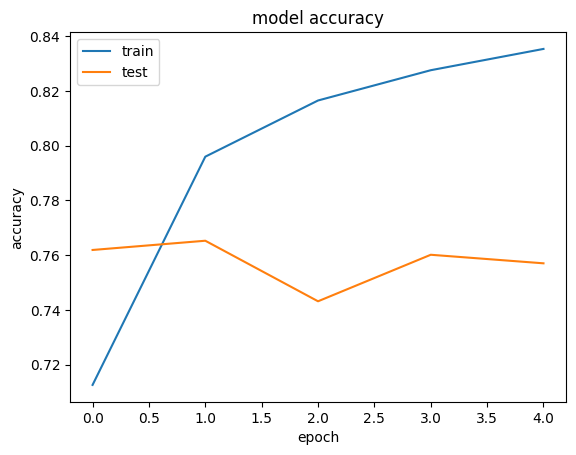

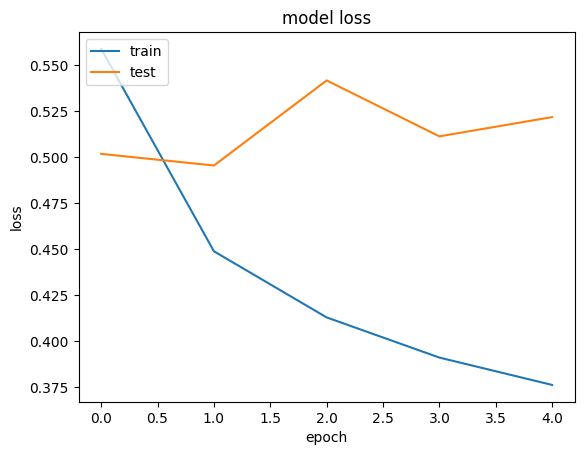

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RNN (LSTM)

In [32]:
from keras.layers import LSTM

In [33]:
# The NN architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_lenght, 100, weights=[embeddings_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [34]:
# Model Compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [35]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 355ms/step - acc: 0.7074 - loss: 0.5635 - val_acc: 0.8020 - val_loss: 0.4520
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 339ms/step - acc: 0.8021 - loss: 0.4347 - val_acc: 0.8185 - val_loss: 0.4080
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 349ms/step - acc: 0.8341 - loss: 0.3815 - val_acc: 0.8514 - val_loss: 0.3524
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 336ms/step - acc: 0.8505 - loss: 0.3516 - val_acc: 0.8429 - val_loss: 0.3581
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 340ms/step - acc: 0.8527 - loss: 0.3410 - val_acc: 0.8637 - val_loss: 0.3300


In [36]:
#Prediction

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - acc: 0.8589 - loss: 0.3376


In [37]:
# Model performance

print("Test Score: ",score[0])
print("Test Accuracy: ",score[1])

Test Score:  0.33544230461120605
Test Accuracy:  0.8590999841690063


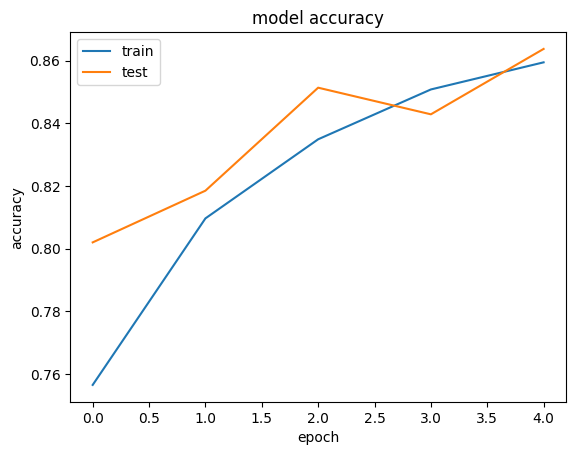

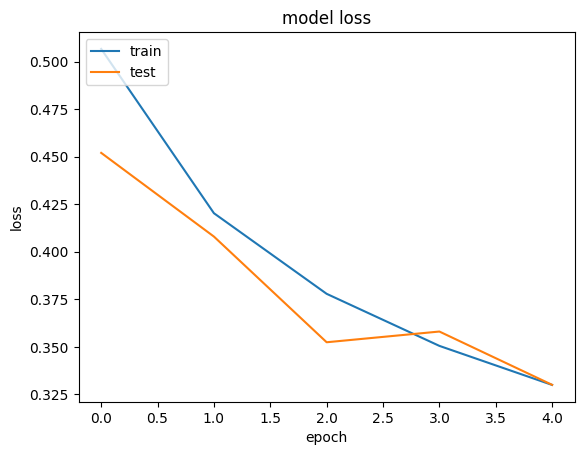

In [38]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RNN(GRUs)

In [39]:
#simple gru model

from keras.layers import GRU
gru_model = Sequential()

embedding_layer = Embedding(vocab_lenght, 100, weights=[embeddings_matrix], input_length=maxlen , trainable=False)
gru_model.add(embedding_layer)
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

In [40]:
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [41]:
# Model Training
gru_model_history = gru_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 419ms/step - acc: 0.6505 - loss: 0.5945 - val_acc: 0.8177 - val_loss: 0.4170
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 404ms/step - acc: 0.8265 - loss: 0.3882 - val_acc: 0.8539 - val_loss: 0.3400
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 429ms/step - acc: 0.8481 - loss: 0.3482 - val_acc: 0.8634 - val_loss: 0.3198
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 97s 387ms/step - acc: 0.8626 - loss: 0.3205 - val_acc: 0.8683 - val_loss: 0.3111
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 381ms/step - acc: 0.8785 - loss: 0.2905 - val_acc: 0.8692 - val_loss: 0.3104


In [42]:
score = gru_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - acc: 0.8613 - loss: 0.3148


In [43]:
# Model performance

print("Test Score: ",score[0])
print("Test Accuracy: ",score[1])

Test Score:  0.31484255194664
Test Accuracy:  0.8636999726295471


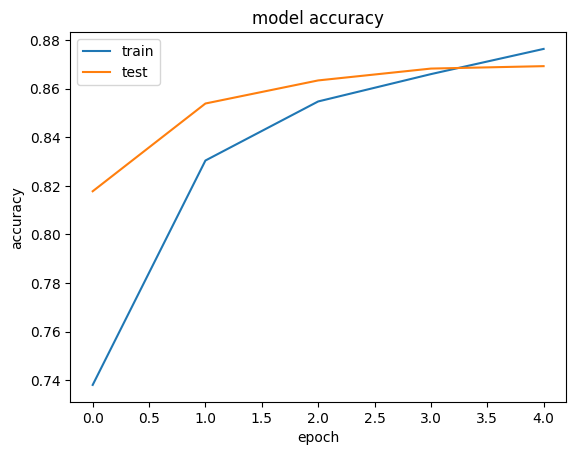

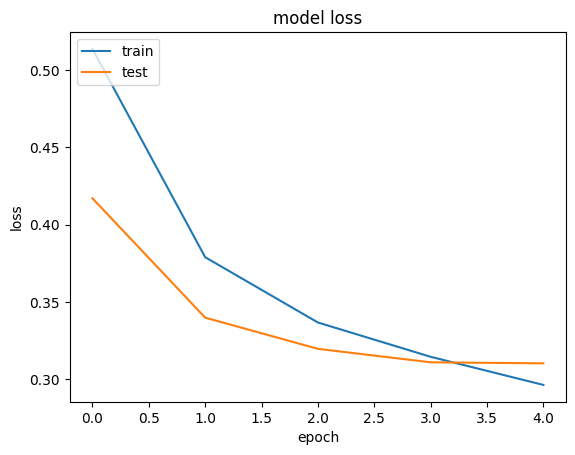

In [44]:
import matplotlib.pyplot as plt

plt.plot(gru_model_history.history['acc'])
plt.plot(gru_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(gru_model_history.history['loss'])
plt.plot(gru_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Live Prediction

In [45]:
!ls

a1_IMDB_Dataset.csv	    a4_LSTM_Predictions.csv
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.864.h5
a3_IMDb_Unseen_Reviews.csv  Movie_review_sentiment_analysis.ipynb


In [46]:
#load IMDb reviews for unseen data

unseen_reviews_data = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

unseen_reviews_data.head(5)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10


In [47]:
# Preprocessing the texts

unseen_reviews = unseen_reviews_data["Review Text"]

unseen_processed = []
for review in unseen_reviews:
  unseen_processed.append(preprocess_text(review))

In [48]:
#Tokenising

unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# padding for equal length

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [49]:
# passing the final instance to the LSTM model

predictions = lstm_model.predict(unseen_padded)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


array([[0.8812993 ],
       [0.9886939 ],
       [0.06723312],
       [0.7331801 ],
       [0.97427106],
       [0.00935701]], dtype=float32)

In [50]:
#Writing the output file

unseen_reviews_data['Predicted Sentiment'] = np.round(predictions*10,1)

df_prediction_sentiments = pd.DataFrame(unseen_reviews_data['Predicted Sentiment'],columns=['Predicted Sentiment'])
df_movie = pd.DataFrame(unseen_reviews_data['Movie'],columns=['Movie'])
df_review = pd.DataFrame(unseen_reviews_data['Review Text'],columns=['Review Text'])
df_imdb_rating = pd.DataFrame(unseen_reviews_data['IMDb Rating'],columns=['IMDb Rating'])

dfx = pd.concat([df_movie, df_review,df_imdb_rating,df_prediction_sentiments], axis=1)
dfx.to_csv("a4_LSTM_Predictions.csv",sep=',',encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiment
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.3
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1


In [51]:
predictions = gru_model.predict(unseen_padded)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


array([[0.8106917 ],
       [0.9847667 ],
       [0.08864857],
       [0.26909792],
       [0.89011633],
       [0.0099435 ]], dtype=float32)

In [52]:
#Writing the output file

unseen_reviews_data['Predicted Sentiment'] = np.round(predictions*10,1)

df_prediction_sentiments = pd.DataFrame(unseen_reviews_data['Predicted Sentiment'],columns=['Predicted Sentiment'])
df_movie = pd.DataFrame(unseen_reviews_data['Movie'],columns=['Movie'])
df_review = pd.DataFrame(unseen_reviews_data['Review Text'],columns=['Review Text'])
df_imdb_rating = pd.DataFrame(unseen_reviews_data['IMDb Rating'],columns=['IMDb Rating'])

dfx = pd.concat([df_movie, df_review,df_imdb_rating,df_prediction_sentiments], axis=1)
dfx.to_csv("a4_LSTM_Predictions.csv",sep=',',encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiment
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.7
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,8.9
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
